## Monitoring convergence of scaling computation

In [1]:
import uproot

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import json
import yaml
from glob import glob
import os
import sys
from pathlib import Path
from collections import defaultdict

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme(context='notebook', font='sans-serif', style='white', palette=None, font_scale=1.5,
              rc={"lines.linewidth": 2.5, "font.sans-serif": 'DejaVu Sans'})
# sns.set_palette('muted') # deep, muted, bright, pastel, dark, colorblind

In [4]:
PATH = Path('../..')
module_path = os.path.abspath(PATH)
if module_path not in sys.path:
    sys.path.append(module_path)

### read feature to be plotted

In [5]:
with open(PATH/'configs/training_v1.yaml') as f:
    scaling_dict = yaml.safe_load(f)

In [6]:
# scaling json doesn't store scaling_type, so read it from the scaling cfg
normal_features = defaultdict(list) # interested only in scaling type "normal", where means/stds were computed
for var_type, var_list in scaling_dict['Features_all'].items():
    for var_dict in var_list:
        var_name = list(var_dict.keys())[0]
        if var_dict[var_name][2] == 'normal':
            normal_features[var_type].append(var_name)
var_types = list(normal_features.keys())

In [7]:
# normal_features

### load scaling snapshots

In [8]:
N_FILES_PER_STEP = 10 # as it was set while running the scaling computation
path_to_snapshots = '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat' # scaling params only for TauFlat variables with processing all Shuffle&Merge files 
version = 'v1_tau'

# N_FILES_PER_STEP = 1
# path_to_snapshots = '/afs/cern.ch/work/o/ofilatov/public/output_json_v1/all_var_types' # scaling params for all var_types all variables with processing 5 first Shuffle&Merge files 
# version = 'v1'

In [9]:
n_snapshots = len(glob(f'{path_to_snapshots}/scaling_params_{version}_log_*.json'))
sorted_file_names = [f'{path_to_snapshots}/scaling_params_{version}_log_{i}.json' for i in range(n_snapshots)]
sorted_file_names += [f'{path_to_snapshots}/scaling_params_{version}.json'] # append final snapshot to the end
sorted_file_names

['/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_0.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_1.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_2.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_3.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_4.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_5.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_6.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_7.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_8.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_log_9.json',
 '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/TauFlat/scaling_params_v1_tau_l

### read into DataFrame

In [10]:
CONE_TYPE = 'global'
mean_dict, std_dict = defaultdict(list), defaultdict(list)
for file_name in sorted_file_names:
    with open(file_name) as f:
        scalings = json.load(f)
    for var_type in scalings.keys():
        mean, std = {}, {}
        for feature, feature_scaling in scalings[var_type].items():
            if CONE_TYPE not in feature_scaling: continue
            if feature not in normal_features[var_type]: continue
            mean[feature] = feature_scaling[CONE_TYPE]['mean']
            std[feature] = feature_scaling[CONE_TYPE]['std']   
        mean_dict[var_type].append(mean) 
        std_dict[var_type].append(std)

In [11]:
df_mean_dict = {var_type: pd.DataFrame(mean_dict[var_type]) for var_type in mean_dict}
df_std_dict = {var_type: pd.DataFrame(std_dict[var_type]) for var_type in std_dict}

### compute running diffs

In [12]:
var_types

['TauFlat',
 'PfCand_electron',
 'PfCand_muon',
 'PfCand_chHad',
 'PfCand_nHad',
 'PfCand_gamma',
 'Electron',
 'Muon']

In [13]:
VAR_TYPE = 'TauFlat'
df_mean = df_mean_dict[VAR_TYPE]
df_std = df_std_dict[VAR_TYPE]
if len(df_mean.columns)==0 and len(df_std.columns)==0:
    raise Exception(f"found no variables with scaling type: 'normal' and cone type: '{var_type}'")

In [14]:
df_mean

,tau_mass,tau_chargedIsoPtSum,tau_footprintCorrection,tau_neutralIsoPtSum,tau_photonPtSumOutsideSignalCone,tau_puCorrPtSum,tau_dxy,tau_dxy_sig,tau_ip3d,tau_ip3d_sig,tau_dz,tau_dz_sig,tau_flightLength_x,tau_flightLength_y,tau_flightLength_z,tau_flightLength_sig,tau_pt_weighted_dr_signal,tau_leadingTrackNormChi2,tau_n_photons,tau_leadChargedCand_etaAtEcalEntrance_minus_tau_eta
0,0.5529,15.15,2.180,11.76,1.187,22.16,0.002237,2.315,0.002990,2.879,0.000079,20.01,-0.001009,-0.000133,-0.002394,-5.667,0.007254,1.713,2.320,0.000170
1,0.5546,15.53,2.193,12.44,1.203,22.17,0.002244,2.340,0.003049,2.912,-0.000048,17.54,-0.000870,-0.000087,-0.000556,-5.634,0.007317,1.713,2.300,0.000208
2,0.5546,15.41,2.192,12.32,1.205,22.16,0.002245,2.339,0.003051,2.910,0.000109,17.94,-0.000632,-0.000205,-0.000709,-5.629,0.007337,1.713,2.296,0.000220
3,0.5551,15.67,2.208,12.61,1.207,22.17,0.002248,2.343,0.003054,2.916,0.000137,17.37,-0.000677,-0.000164,-0.000654,-5.620,0.007337,1.713,2.306,0.000214
4,0.5552,15.63,2.213,12.59,1.207,22.17,0.002245,2.340,0.003049,2.912,0.000075,17.30,-0.000692,-0.000153,-0.000698,-5.623,0.007327,1.713,2.305,0.000210
5,0.5551,15.58,2.213,12.53,1.206,22.17,0.002242,2.338,0.003042,2.909,0.000080,17.28,-0.000690,-0.000147,-0.000656,-5.627,0.007316,1.712,2.305,0.000214
6,0.5549,15.49,2.205,12.40,1.205,22.16,0.002241,2.337,0.003043,2.908,0.000118,17.40,-0.000703,-0.000111,-0.000753,-5.630,0.007313,1.712,2.302,0.000210
7,0.5549,15.46,2.201,12.38,1.206,22.16,0.002245,2.339,0.003047,2.910,0.000066,17.57,-0.000775,-0.000129,-0.000771,-5.626,0.007317,1.711,2.300,0.000208
8,0.5549,15.40,2.196,12.32,1.206,22.16,0.002246,2.339,0.003050,2.911,0.000035,17.60,-0.000788,-0.000121,-0.000686,-5.625,0.007321,1.712,2.298,0.000207
9,0.5548,15.33,2.192,12.25,1.205,22.16,0.002247,2.340,0.003052,2.911,0.000050,17.54,-0.000775,-0.000145,-0.000699,-5.624,0.007323,1.712,2.296,0.000204


In [15]:
df_std

,tau_mass,tau_chargedIsoPtSum,tau_footprintCorrection,tau_neutralIsoPtSum,tau_photonPtSumOutsideSignalCone,tau_puCorrPtSum,tau_dxy,tau_dxy_sig,tau_ip3d,tau_ip3d_sig,tau_dz,tau_dz_sig,tau_flightLength_x,tau_flightLength_y,tau_flightLength_z,tau_flightLength_sig,tau_pt_weighted_dr_signal,tau_leadingTrackNormChi2,tau_n_photons,tau_leadChargedCand_etaAtEcalEntrance_minus_tau_eta
0,0.5362,39.50,6.616,39.94,3.821,13.02,0.009857,4.226,0.01333,4.514,0.5022,217.7,0.3863,0.3821,1.072,8.700,0.01853,5.189,3.065,0.03668
1,0.5375,45.71,7.025,49.18,3.847,13.29,0.009905,4.277,0.01477,4.577,0.4633,199.5,0.3911,0.3954,1.104,8.776,0.01858,5.198,3.036,0.03735
2,0.5369,45.47,7.035,49.28,3.848,13.15,0.009905,4.277,0.01444,4.580,0.4693,202.7,0.3907,0.3929,1.098,8.795,0.01861,5.204,3.039,0.03728
3,0.5374,46.56,7.145,50.62,3.870,13.32,0.009911,4.281,0.01422,4.585,0.4602,198.6,0.3944,0.3964,1.113,8.812,0.01862,5.202,3.047,0.03735
4,0.5375,46.68,7.225,51.33,3.882,13.29,0.009895,4.274,0.01404,4.577,0.4596,198.3,0.3933,0.3971,1.111,8.797,0.01861,5.197,3.044,0.03724
5,0.5374,46.19,7.200,50.63,3.883,13.24,0.009885,4.270,0.01391,4.570,0.4595,198.1,0.3920,0.3959,1.107,8.787,0.01859,5.198,3.042,0.03709
6,0.5373,45.50,7.137,49.47,3.878,13.17,0.009883,4.267,0.01385,4.567,0.4617,199.2,0.3909,0.3947,1.103,8.785,0.01859,5.195,3.038,0.03720
7,0.5373,45.62,7.129,49.73,3.884,13.18,0.009892,4.272,0.01385,4.574,0.4644,200.5,0.3910,0.3946,1.102,8.798,0.01859,5.192,3.036,0.03722
8,0.5374,45.43,7.104,49.44,3.876,13.15,0.009892,4.273,0.01393,4.575,0.4649,200.8,0.3909,0.3940,1.101,8.804,0.01859,5.193,3.034,0.03732
9,0.5373,45.20,7.085,49.28,3.874,13.13,0.009895,4.275,0.01389,4.577,0.4638,200.4,0.3910,0.3946,1.102,8.810,0.01859,5.193,3.031,0.03725


In [16]:
print('mean: ')
print('  NaN columns: ', list(df_mean.columns[df_mean.isna().any()]))
print('  inf columns: ', list(df_mean.columns[np.isinf(df_mean).any()]))

print('\nstd: ')
print('  NaN columns: ', list(df_std.columns[df_std.isna().any()]))
print('  inf columns: ', list(df_std.columns[np.isinf(df_std).any()]))

mean: 
  NaN columns:  []
  inf columns:  []

std: 
  NaN columns:  []
  inf columns:  []


In [17]:
not_inf_columns = list(df_mean.columns[~np.isinf(df_mean).any()])
df_mean = df_mean[not_inf_columns].dropna(axis=1, how='any')
print(df_mean.columns[np.isinf(df_mean).any()])
#
not_inf_columns = list(df_std.columns[~np.isinf(df_std).any()])
df_std = df_std[not_inf_columns].dropna(axis=1, how='any')
#
print(df_std.columns[np.isinf(df_std).any()])

Index([], dtype='object')
Index([], dtype='object')


In [18]:
# running diffs = difference of mean/std value between two consecutive snapshots, normalised by the value
running_diff_mean = abs(df_mean.iloc[1:].values - (df_mean.iloc[0:-1].values)) / abs(df_mean.iloc[0:-1])
running_diff_std = abs(df_std.iloc[1:].values - (df_std.iloc[0:-1].values)) / abs(df_std.iloc[0:-1])

In [19]:
# append to the end difference between 1st and final snapshots 
running_diff_mean.iloc[-1] = abs(df_mean.iloc[-1].values - (df_mean.iloc[0].values)) / abs(df_mean.iloc[0])
running_diff_std.iloc[-1] = abs(df_std.iloc[-1].values - (df_std.iloc[0].values)) / abs(df_std.iloc[0])

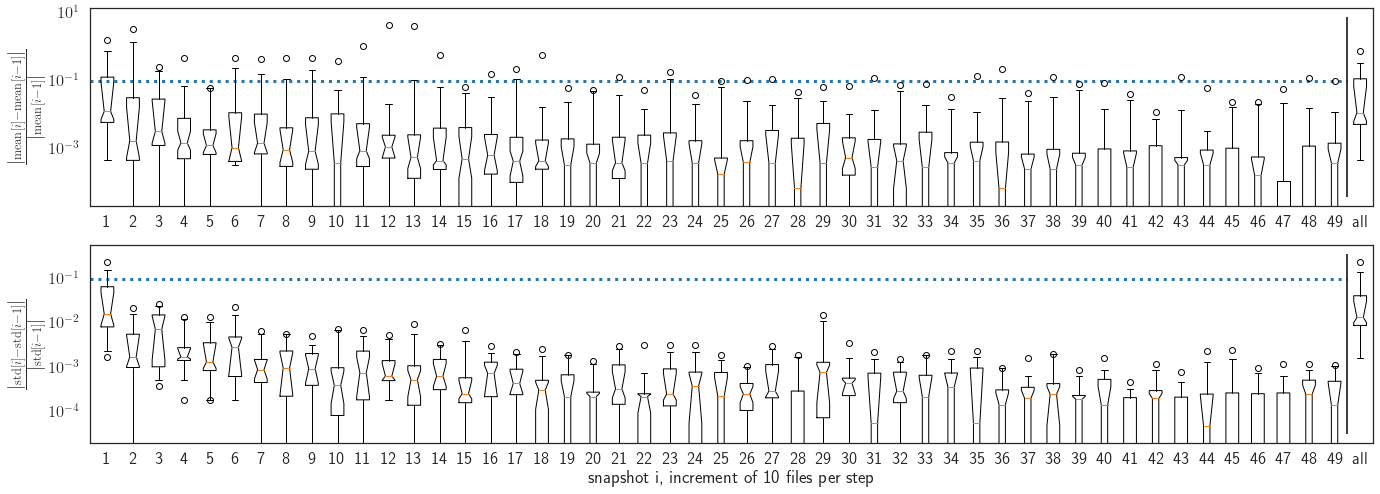

In [20]:
plt.rcParams['text.usetex'] = True 
fig, axs = plt.subplots(2, 1, figsize=(23,8))

axs[0].boxplot(list(running_diff_mean.values), notch=True, bootstrap=10000, whis=(5, 95))
# axs[0].set_title(f'\text{VAR_TYPE}{CONE_TYPE_STR}')
axs[0].set_ylabel(r'$\frac{\Big|\mathrm{mean}[i] - \mathrm{mean}[i-1]\Big|}{\Big|\mathrm{mean}[i-1]\Big|}$')
axs[0].set_yscale('log')
axs[0].set_xlim(.3, axs[0].get_xlim()[1])
axs[0].set_xticks(list(range(1, n_snapshots+1)))
axs[0].set_xticklabels(list(range(1, n_snapshots))+['all'])
axs[0].hlines(.1, axs[0].get_xlim()[0], axs[0].get_xlim()[1]-1, ls=':', linewidth=3, label='10\% level')
axs[0].vlines(49.5, *axs[0].get_ylim(), 'black', linewidth=1.5)
#
axs[1].boxplot(list(running_diff_std.values), notch=True, bootstrap=10000, whis=(5, 95))
axs[1].set_ylabel(r'$\frac{\Big|\mathrm{std}[i] - \mathrm{std}[i-1]\Big|}{\Big|\mathrm{std}[i-1]\Big|}$')
axs[1].set_yscale('log')
axs[1].set_xlabel(f'snapshot i, increment of {N_FILES_PER_STEP} files per step')
axs[1].set_xlim(.3, axs[1].get_xlim()[1])
axs[1].set_xticks(list(range(1, n_snapshots+1)))
axs[1].set_xticklabels(list(range(1, n_snapshots))+['all'])
axs[1].hlines(.1, axs[1].get_xlim()[0], axs[1].get_xlim()[1]-1, ls=':', linewidth=3, label='10\% level')
axs[1].vlines(49.5, *axs[1].get_ylim(), 'black', linewidth=1.5)
# plt.legend(loc='upper center')
plt.show()

## Quantile validation 

In [21]:
from python.quantile_validation import plot_ranges

In [22]:
path_to_params = '/afs/cern.ch/work/o/ofilatov/public/scaling_v1/all_var_types'
file_id = 0 # quantile ranges are computed per Shuffle&Merge file

In [23]:
with open(PATH/'configs/training_v1.yaml', 'r') as f:
    training_cfg = yaml.safe_load(f)

In [24]:
with open(f'{path_to_params}/quantile_params_v1_fid_{file_id}.json', 'r') as f:
    quantile_params = json.load(f)

In [25]:
with open(f'{path_to_params}/scaling_params_v1.json', 'r') as f:
    scaling_params = json.load(f)

In [26]:
var_type = 'PfCand_chHad'
var_name = 'pfCand_chHad_rel_pt'
cone_type = 'inner'

In [27]:
for var_dict in training_cfg['Features_all'][var_type]:
    if var_name in var_dict.keys():
        var_scaling_type = var_dict[var_name][2]
        break
var_scaling_type

'normal'

In [28]:
var_quantiles = quantile_params[var_type][var_name][cone_type][str(file_id)]
var_scaling = scaling_params[var_type][var_name][cone_type]

In [29]:
var_quantiles

{'median': 0.14204025268554688,
 'min': 0.0001892082509584725,
 'max': 40.45664596557617,
 '1sigma': {'left': 0.018905488497260217, 'right': 0.4383216648439078},
 '2sigma': {'left': 0.004777174615367081, 'right': 0.9023162237998543},
 '3sigma': {'left': 0.0013282460580801856, 'right': 2.802788207197464},
 '5sigma': {'left': 0.00020081878574952264, 'right': 37.06446569468059}}

In [30]:
var_scaling

{'mean': 0.2296, 'std': 0.3576, 'lim_min': -5, 'lim_max': 5}

In [31]:
### fetch clamping params
mean = var_scaling['mean']
clamp_range_left = mean + var_scaling['lim_min']*var_scaling['std']
clamp_range_right = mean + var_scaling['lim_max']*var_scaling['std']
clamp_range = [clamp_range_left, clamp_range_right]

### fetch quantiles
median = var_quantiles['median']
min_value = var_quantiles['min']
max_value = var_quantiles['max']
#
one_sigma_left = var_quantiles['1sigma']['left']
one_sigma_right = var_quantiles['1sigma']['right']
one_sigma_range = [one_sigma_left, one_sigma_right]
#
two_sigma_left = var_quantiles['2sigma']['left']
two_sigma_right = var_quantiles['2sigma']['right']
two_sigma_range = [two_sigma_left, two_sigma_right]
#
three_sigma_left = var_quantiles['3sigma']['left']
three_sigma_right = var_quantiles['3sigma']['right']
three_sigma_range = [three_sigma_left, three_sigma_right]

In [32]:
suspicious_dict = {}
suspicious_dict['left_out'] = clamp_range_left > two_sigma_left
suspicious_dict['right_out'] = clamp_range_right < two_sigma_right
suspicious_dict['one_sigma_empty'] = one_sigma_left == one_sigma_right
suspicious_dict['two_sigma_empty'] = two_sigma_left == two_sigma_right
suspicious_dict['three_sigma_empty'] = three_sigma_left == three_sigma_right

In [33]:
### cosmetics
xscale = clamp_range_right - clamp_range_left
yscale = 1
level_quantile = 0
level_clamp = level_quantile+3*yscale
bar_height = 1.5*yscale
xlim = [mean-.9*xscale, mean+1.*xscale]
ylim = [level_quantile-2*yscale, level_clamp+13.*yscale]

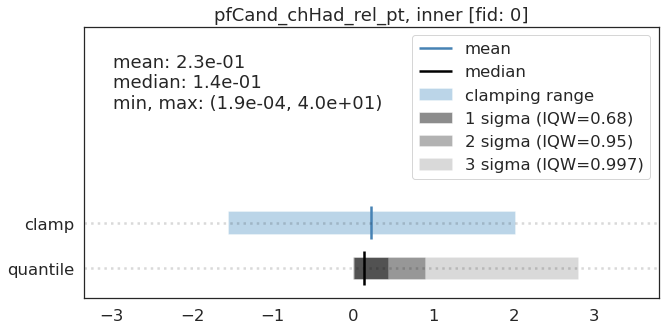

In [34]:
plt.rcParams['text.usetex'] = False 
plot_ranges(file_id, var_name, cone_type, None if var_scaling_type=='linear' else mean, median, min_value, max_value,
                                clamp_range, one_sigma_range, two_sigma_range, three_sigma_range,
                                suspicious_dict=suspicious_dict, savepath=None, close_plot=False)